# Final project guidelines

**Note:** Use these guidelines if and only if you are pursuing a **final project of your own design**. For those taking the final exam instead of the project, see the (separate) [final exam notebook](https://github.com/wilkens-teaching/info3350-s22/blob/main/final_exam/exam.ipynb).

## Guidelines

These guidelines are intended for **undergraduates enrolled in INFO 3350**. If you are a graduate student enrolled in INFO 6350, you're welcome to consult the information below, but you have wider latitude to design and develop your project in line with your research goals.

### The task

Your task is to: identify an interesting problem connected to the humanities or humanistic social sciences that's addressable with the help of computational methods, formulate a hypothesis about it, devise an experiment or experiments to test your hypothesis, present the results of your investigations, and discuss your findings.

These tasks essentially replicate the process of writing an academic paper. You can think of your project as a paper in miniature.

You are free to present each of these tasks as you see fit. You should use narrative text (that is, your own writing in a markdown cell), citations of others' work, numerical results, tables of data, and static and/or interactive visualizations as appropriate. Total length is flexible and depends on the number of people involved in the work, as well as the specific balance you strike between the ambition of your question and the sophistication of your methods. But be aware that numbers never, ever speak for themselves. Quantitative results presented without substantial discussion will not earn high marks. 

Your project should reflect, at minimum, ten or more hours of work by each participant, though you will be graded on the quality of your work, not the amount of time it took you to produce it.

#### Pick an important and interesting problem!

No amount of technical sophistication will overcome a fundamentally uninteresting problem at the core of your work. You have seen many pieces of successful computational humanities research over the course of the semester. You might use these as a guide to the kinds of problems that interest scholars in a range of humanities disciplines. You may also want to spend some time in the library, reading recent books and articles in the professional literature. **Problem selection and motivation are integral parts of the project.** Do not neglect them.

### Format

You should submit your project as a Jupyter notebook, along with all data necessary to reproduce your analysis. If your dataset is too large to share easily, let us know in advance so that we can find a workaround. If you have a reason to prefer a presentation format other than a notebook, likewise let us know so that we can discuss the options.

Your report should have four basic sections (provided in cells below for ease of reference):

1. **Introduction and hypothesis.** What problem are you working on? Why is it interesting and important? What have other people said about it? What do you expect to find?
2. **Corpus, data, and methods.** What data have you used? Where did it come from? How did you collect it? What are its limitations or omissions? What major methods will you use to analyze it? Why are those methods the appropriate ones?
3. **Results.** What did you find? How did you find it? How should we read your figures?
4. **Discussion and conclusions.** What does it all mean? Do your results support your hypothesis? Why or why not? What are the limitations of your study and how might those limitations be addressed in future work?

Within each of those sections, you may use as many code and markdown cells as you like. You may, of course, address additional questions or issues not listed above.

All code used in the project should be present in the notebook (except for widely-available libraries that you import), but **be sure that we can read and understand your report in full without rerunning the code**. Be sure, too, to explain what you're doing along the way, both by describing your data and methods and by writing clean, well commented code.

### Grading

This project takes the place of the take-home final exam for the course. It is worth 20% of your overall grade. You will be graded on the quality and ambition of each aspect of the project. No single component is more important than the others.

### Practical details

* The project is due at **11:59pm EST on Thursday, May 19, 2022** via upload to CMS of a single zip file containing your fully executed Jupyter notebook and all associated data.
* You may work alone or in a group of up to three total members.
    * If you work in a group, be sure to list the names of the group members.
    * For groups, create your group on CMS and submit one notebook for the entire group. **Each group member should also submit an individual statement of responsibility** that describes in general terms who performed which parts of the project.
* You may post questions on Ed, but should do so privately (visible to course staff only).
* Interactive visualizations do not always work when embedded in shared notebooks. If you plan to use interactives, you may need to host them elsewhere and link to them.

---

## 1. Introduction and hypothesis

## 2. Data and methods

In [778]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_extraction.text import CountVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_classif
from   sklearn.linear_model import LogisticRegression, LinearRegression
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
from   sklearn.decomposition import LatentDirichletAllocation

In [779]:
def song_data(date=''):
    '''
    The Billboard Hot 100 chart represents the Hot 100 songs for that week.
    
    date: a string, in the form "YYYY-MM-DD". For example, "2022-05-16" represents May 16, 2022. If no date specified, function
          will select the present chart
    returns: a pandas dataframe containing metadata for Billboard Hot 100 songs of the week of the specified date.
    columns: rank: rank of the week (1-100)
             date: a pandas datetime object. date of the chart as stated on the Billboard website, 
             which uses the Saturday to identify the week (so it is the same week as the user input, but the Saturday
             of that week),
             title: title of the song,
             artist1: main artist,
             artist2: a list of the rest of the artists. np.nan if there are none.
             peak_pos: peak position of the song,
             wks_chart: # of weeks the song has been on the chart
             b_url: url to the billboard chart
    '''
    lsongs=[]
    lartists=[]
    artist1=[]
    artist2=[]
    lpeak_pos=[]
    lwks_chart=[]
    
    URL='https://www.billboard.com/charts/hot-100/'+date

    page=requests.get(URL)
    soup=BeautifulSoup(page.content, 'lxml')
  
    ### get the first song, bc it's in a different div container
    song1 = soup.find("h3",id='title-of-a-story', class_="c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 u-font-size-23@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-245 u-max-width-230@tablet-only u-letter-spacing-0028@tablet")
    lsongs.append(song1.text.strip())
    
    ### get the first artist, bc it's in a different div container
    artistf=soup.find("span", class_="c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only u-font-size-20@tablet")
    lartists.append(artistf.text.strip())
    
    ### get the first peak position, bc it's in a different div container
    nums=soup.find_all('span', class_="c-label a-font-primary-bold-l a-font-primary-m@mobile-max u-font-weight-normal@mobile-max lrv-u-padding-tb-050@mobile-max u-font-size-32@tablet")
    nums1=[]
    for x in nums:
        nums1.append(x.text.strip())
        
    lpeak_pos.append(nums1[1])
    ### get the first weeks on chart, bc it's in a different div container
    lwks_chart.append(nums1[2])
    
    ### get last 99 songs
    songs = soup.find_all("h3", class_="c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 lrv-u-font-size-18@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-330 u-max-width-230@tablet-only", id="title-of-a-story")
    for song in songs:
        lsongs.append(song.text.strip())
    
    ### get last 99 artists
    artists = soup.find_all("span", class_="c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only")
    for artist in artists:
        lartists.append(artist.text.strip())
        
    ### get last 99 peak position
    all_num=[]
    peak_pos = soup.find_all("span", class_="c-label a-font-primary-m lrv-u-padding-tb-050@mobile-max")
    for num in peak_pos:
        all_num.append(num.text.strip())
    
    x=1
    for peak in all_num:
        if x <= len(all_num)-5:
            lpeak_pos.append(all_num[x])
            x=x+6

    ### get last 99 weeks on chart
    y=2
    for wk in all_num:
        if y <= len(all_num)-4:
            lwks_chart.append(all_num[y])
            y=y+6            
    
    ### get date as listed on the chart, aka the Saturday of the week of the user input
    date=soup.find('h2', id="section-heading")
    cdate=pd.to_datetime(date.text.strip().replace("Week of ",''))
    
    
    ### separate artists into artist1 and artist2
    for a in lartists:
        if ("X &" not in a) and ("X Featuring" not in a) and ("X /" not in a):
            a=a.replace(" X ",",")
        a=a.replace("Featuring",",")
        a=a.replace("&",",")   
        a=a.replace(" / ",",")
        List=a.split(",")
        artists = [i.strip() for i in List]
        artist1.append(artists[0])
        if len(artists)==1:
            artist2.append(np.nan)
        else:
            artist2.append(artists[1:])
    
    metadata=pd.DataFrame()
    metadata['rank']=(range(1,101)) ### get rank position
    metadata['date']=cdate
    metadata['title']=lsongs
    metadata['artist1']=artist1
    metadata['artist2']=artist2
    metadata['peak_pos']=lpeak_pos
    metadata['wks_chart']=lwks_chart
    metadata['b_url']=URL
    
    metadata=append_lyrics(metadata)
    metadata.reset_index(inplace=True, drop=True)

    return metadata

In [4]:
def append_lyrics(metadata):
    '''
    a helper function for song_data(). gets the song lyrics for a given song. appends the
    song lyrics for a song from Genius.com to a "lyrics" column.
    
    If the function cannot find the song on the Genius lyrics website, it will drop the entire observation from the dataset.
    
    metadata: a pandas dataframe, created from song_data(). at the least contains
              the title column and the artist1 column.
    returns: a pandas dataframe of the original dataframe with a lyrics column and URL to the
             Genius website the lyrics were taken from.
    '''
    all_lyrics=[]
    all_URL=[]
    title=metadata.title.values
    artist1=metadata.artist1.values
    for x in range(len(title)):
        t=title[x]
        a=artist1[x]
  
        t=re.sub(r'[^\w\s]', '', t)
        a=re.sub(r'[!$/]', '-', a)
        a=re.sub(r'["\\#%&;\()*\[\]+,.:;<=>?@^_`{|}~]', '', a) #[\\]
        URL= "https://www.genius.com/"+a.replace(' ','-')+'-'+t.replace(' ','-')+'-lyrics'
        URL=URL.replace('--','-')
        
        page=requests.get(URL)
        soup=BeautifulSoup(page.content, 'lxml')
        if 'Oops! Page not found' not in soup.text.strip():
            lyrics=soup.find_all('div', class_='Lyrics__Container-sc-1ynbvzw-6 jYfhrf')
            Lyrics = [re.sub(r"\[.*?\]",'',i.text.strip()) for i in lyrics]
            LYRICS=" ".join(Lyrics)
            all_lyrics.append(LYRICS)
            all_URL.append(URL)
        
        else: 
            #print(URL)
            metadata.drop([x], inplace=True)
    
    metadata['lyrics']=all_lyrics
    metadata['g_url']=all_URL
    return metadata

In [6]:
dates=pd.date_range(start='2000-07-15',end='2000-12-31',freq='W-SAT')
print(len(dates))
print(dates)

25
DatetimeIndex(['2000-07-15', '2000-07-22', '2000-07-29', '2000-08-05',
               '2000-08-12', '2000-08-19', '2000-08-26', '2000-09-02',
               '2000-09-09', '2000-09-16', '2000-09-23', '2000-09-30',
               '2000-10-07', '2000-10-14', '2000-10-21', '2000-10-28',
               '2000-11-04', '2000-11-11', '2000-11-18', '2000-11-25',
               '2000-12-02', '2000-12-09', '2000-12-16', '2000-12-23',
               '2000-12-30'],
              dtype='datetime64[ns]', freq='W-SAT')


In [15]:
Dates=[date.strftime('%Y-%m-%d') for date in dates]

In [16]:
songs=[]
for date in Dates:
    songs.append(song_data(date))
    print(date)

2000-07-15
2000-07-22
2000-07-29
2000-08-05
2000-08-12
2000-08-19
2000-08-26
2000-09-02
2000-09-09
2000-09-16
2000-09-23
2000-09-30
2000-10-07
2000-10-14
2000-10-21
2000-10-28
2000-11-04
2000-11-11
2000-11-18
2000-11-25
2000-12-02
2000-12-09
2000-12-16
2000-12-23
2000-12-30


In [25]:
df=pd.concat(songs)
df.reset_index(inplace=True)

In [32]:
df=df.iloc[:,1:]

In [33]:
df2=pd.read_csv('df2000_0101_to_2000_0708.csv')

In [36]:
df2=df2.iloc[:,2:]

In [38]:
songs2000=pd.concat([df,df2])
songs2000.reset_index(inplace=True, drop=True)

In [40]:
songs2000.to_csv('songs2000.csv')

In [48]:
songs2000

,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,lyrics,g_url
0,1,2000-07-15 00:00:00,Everything You Want,Vertical Horizon,NaN,1,26,https://www.billboard.com/charts/hot-100/2000-...,Somewhere there's speakingIt's already coming ...,https://www.genius.com/Vertical-Horizon-Everyt...
1,2,2000-07-15 00:00:00,Try Again,Aaliyah,NaN,1,18,https://www.billboard.com/charts/hot-100/2000-...,It's been a long time (Long time)We shouldn't ...,https://www.genius.com/Aaliyah-Try-Again-lyrics
2,3,2000-07-15 00:00:00,Be With You,Enrique Iglesias,NaN,1,16,https://www.billboard.com/charts/hot-100/2000-...,Monday night and I feel so lowI count the hour...,https://www.genius.com/Enrique-Iglesias-Be-Wit...
3,4,2000-07-15 00:00:00,I Wanna Know,Joe,NaN,4,29,https://www.billboard.com/charts/hot-100/2000-...,"YeahOh-oh, yeahAlright, oh, oh, ohIt's amazing...",https://www.genius.com/Joe-I-Wanna-Know-lyrics
4,6,2000-07-15 00:00:00,Bent,matchbox twenty,NaN,6,12,https://www.billboard.com/charts/hot-100/2000-...,And if I fall along the wayPick me up and dust...,https://www.genius.com/matchbox-twenty-Bent-ly...
...,...,...,...,...,...,...,...,...,...,...
4821,95,2000-07-08,What You Want,DMX,['Sisqo'],95,2,https://www.billboard.com/charts/hot-100/2000-...,"Y'all niggas is dead, dead!What the fuck is wr...",https://www.genius.com/DMX-What-You-Want-lyrics
4822,96,2000-07-08,You Owe Me,NAS,['Ginuwine'],59,16,https://www.billboard.com/charts/hot-100/2000-...,"Uh, it's real, it's real, it's realUh, uh, owe...",https://www.genius.com/NAS-You-Owe-Me-lyrics
4823,97,2000-07-08,Dancing Queen,A*Teens,NaN,97,1,https://www.billboard.com/charts/hot-100/2000-...,"Ooh, you can danceYou can jiveHaving the time ...",https://www.genius.com/ATeens-Dancing-Queen-ly...
4824,98,2000-07-08,Don't Call Me Baby,Madison Avenue,NaN,98,1,https://www.billboard.com/charts/hot-100/2000-...,"You and me, we have an opportunityAnd we could...",https://www.genius.com/Madison-Avenue-Dont-Cal...


## 3. Results

## 4. Discussion and conclusions

resources consulted
https://stackoverflow.com/questions/640001/how-can-i-remove-text-within-parentheses-with-a-regex
https://www.pythontutorial.net/python-regex/python-regex-sub/
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html

In [784]:
songs = pd.read_csv('songs.csv')

In [785]:
songs=songs.iloc[:,1:]
songs

,rank,date,title,artist1,artist2,peak_pos,wks_chart,b_url,g_url,lyrics
0,1,1960-01-04,El Paso,Marty Robbins,NaN,1,9,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Marty-Robbins-El-Paso-l...,Out in the West Texas town of El PasoI fell in...
1,2,1960-01-04,Why,Frankie Avalon,NaN,1,7,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Frankie-Avalon-Why-lyrics,I'll never let you goWhy? Because I love youI'...
2,4,1960-01-04,Running Bear,Johnny Preston,NaN,4,12,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Johnny-Preston-Running-...,"On the bank of the riverStood Running Bear, yo..."
3,6,1960-01-04,Heartaches By The Number,Guy Mitchell,NaN,1,14,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Guy-Mitchell-Heartaches...,"Heartaches by the number, troubles by the scor..."
4,7,1960-01-04,It's Time To Cry,Paul Anka,NaN,4,7,https://www.billboard.com/charts/hot-100/1960-...,https://www.genius.com/Paul-Anka-Its-Time-To-C...,"When somebody leaves you, that's the time to c..."
...,...,...,...,...,...,...,...,...,...,...
262298,95,2021-12-25,Freedom Was A Highway,Jimmie Allen,['Brad Paisley'],76,10,https://www.billboard.com/charts/hot-100/2021-...,https://www.genius.com/Jimmie-Allen-Freedom-Wa...,"(Oh-oh, oh-oh, woo)(Oh-oh, oh-oh)Sunset throug..."
262299,96,2021-12-25,No Love,Summer Walker,['SZA'],13,6,https://www.billboard.com/charts/hot-100/2021-...,https://www.genius.com/Summer-Walker-No-Love-l...,"Oh, ooh woahOh-oh, yeahYeah, yeah, yeahIf I ha..."
262300,97,2021-12-25,Bad Man (Smooth Criminal),Polo G,NaN,49,5,https://www.billboard.com/charts/hot-100/2021-...,https://www.genius.com/Polo-G-Bad-Man-Smooth-C...,"Lil Capalot, bitch, haSmooth criminal, Mike Ja..."
262301,98,2021-12-25,Feel Alone,Juice WRLD,NaN,98,1,https://www.billboard.com/charts/hot-100/2021-...,https://www.genius.com/Juice-WRLD-Feel-Alone-l...,"Smokin' this dope, relaxin'I ain't gon' lie, b..."


### Topic Modeling the Songs

In [437]:
lyrics=songs['lyrics'].dropna().unique().tolist()
print("Lyrics of first song:\n", lyrics[0])
print("\nNumber of songs:", len(lyrics))
print("\nDates:", min(songs.date), 'through', max(songs.date))

Lyrics of first song:
 Man, it's a hot oneLike seven inches from the midday sunI hear you whisper and the words melt everyoneBut you stay so coolMy muñequita, my Spanish Harlem Mona LisaYou're my reason for reason, the step in my grooveAnd if you say this life ain't good enoughI would give my world to lift you upI could change my life to better suit your moodBecause you're so smoothAnd it's just like the ocean under the moonIt's the same as the emotion that I get from youYou got the kind of loving that can be so smoothGimme your heart, make it real, or else forget about itI'll tell you one thingIf you would leave it would be a crying shameIn every breath and every wordI hear your name calling me outOut from the barrio, you hear my rhythm on the radioYou feel the turning of the world so soft and slow, turnin' you round and roundAnd if you said, "This life ain't good enough"I'd give my world to lift you upI could change my life to better suit your moodBecause you're so smooth, andOh, and

In [407]:
# Vectorize

vectorizer = CountVectorizer( #token counts
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    #stop_words='english', 
    lowercase = True,
    min_df = 0.1, #chunk by song
    max_df = 0.9    
)

X = vectorizer.fit_transform(lyrics)
print("Feature matrix shape:", X.shape)
print("Total vectorized words in the corpus:", X.sum())
print("Average vectorized song length:", int(X.sum()/X.shape[0]), "tokens")

Feature matrix shape: (8468, 204)
Total vectorized words in the corpus: 1665054
Average vectorized song length: 196 tokens


In [481]:
lda = LatentDirichletAllocation(
    n_components=10, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=20,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20, perplexity: 119.4231
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20, perplexity: 115.6463
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20, perplexity: 114.2672
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20, perplexity: 113.5157
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20, perplexity: 113.0414
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20, perplexity: 112.7044
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20, perplexity: 112.4348
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20, perplexity: 112.2297
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20, perplexity: 112.0805
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20, perplexity: 111.9721


LatentDirichletAllocation(evaluate_every=2, max_iter=20, n_jobs=-1, verbose=1)

In [482]:
# source: lecture 20-21 topic models

def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)    
        print(message)
    print()

In [483]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=20, hide_stops=False)

Topic  0: my on in that got up with they ain and like it nigga bitch me get shit yeah fuck no
Topic  1: it get up on let go ooh down and your me make ya can we back in come put baby
Topic  2: it know ve that never don just been can could this so be not is but feel all cause think
Topic  3: oh hey uh yeah ooh my and me it your so this no in like on bad now night got
Topic  4: in and my of on all was that for is up your out this back me it when we at
Topic  5: my be your can ll don me wanna and on for in just take with of will need that won
Topic  6: we re gonna are what one and who only if where say our of run is world your know us
Topic  7: me love no baby with can tell don my ma way ain if in so need ya when and am
Topic  8: yeah that me like do what know want it don girl so your all and is wanna my got just
Topic  9: she her he it and that in like got him said his on girl with bad when out my can



In [484]:
# Install pyLDAvis
#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge pyldavis

In [485]:
import pyLDAvis
import pyLDAvis.sklearn
import warnings

pyLDAvis.enable_notebook()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_vis = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='pcoa', sort_topics=False)
pyLDAvis.display(lda_vis)

/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/gabychu/opt/anaconda3

In [486]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    doc_topic_matrix = lda.transform(X)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

Doc-topic matrix shape: (8468, 10)


### SVD Visualization

In [487]:
import datetime

In [735]:
songs['year'] = songs['date'].str[0:4]
songs_trun=songs[['artist1', 'lyrics', 'g_url']].drop_duplicates()
songs_trun.dropna(inplace=True)
songs_trun

,artist1,lyrics,g_url
0,Santana,"Man, it's a hot oneLike seven inches from the ...",https://www.genius.com/Santana-Smooth-lyrics
1,Brian McKnight,It's undeniableThat we should be togetherIt's ...,https://www.genius.com/Brian-McKnight-Back-At-...
2,Jessica Simpson,"Ooh, ooh, mmmYou set my soul at easeChased dar...",https://www.genius.com/Jessica-Simpson-I-Wanna...
3,Whitney Houston,"Clap your hands, y'allIt's alright (Turn me up...",https://www.genius.com/Whitney-Houston-My-Love...
4,Savage Garden,"MmmOoh, ohMaybe it's intuitionBut some things ...",https://www.genius.com/Savage-Garden-I-Knew-I-...
...,...,...,...
105925,Juice WRLD,"She said it's not enoughOh-oh-oh, uhNow I've b...",https://www.genius.com/Juice-WRLD-Not-Enough-l...
105926,A Boogie Wit da Hoodie,Got it on Smash (OG Parker)Huh? She whisperin'...,https://www.genius.com/A-Boogie-Wit-da-Hoodie-...
105930,Juice WRLD,"Uh, yeahEcstasy-takin', rock star steezEcstasy...",https://www.genius.com/Juice-WRLD-From-My-Wind...
105931,Juice WRLD,"You know, I think more than meBecause he did a...",https://www.genius.com/Juice-WRLD-Relocate-lyrics


In [736]:
same_songs = songs.groupby('g_url')
years = round(same_songs.year.median())
years=pd.DataFrame(years)
songs_trun=songs_trun.merge(years, on='g_url')

In [737]:
songs_trun

,artist1,lyrics,g_url,year
0,Santana,"Man, it's a hot oneLike seven inches from the ...",https://www.genius.com/Santana-Smooth-lyrics,2000.0
1,Brian McKnight,It's undeniableThat we should be togetherIt's ...,https://www.genius.com/Brian-McKnight-Back-At-...,2000.0
2,Jessica Simpson,"Ooh, ooh, mmmYou set my soul at easeChased dar...",https://www.genius.com/Jessica-Simpson-I-Wanna...,2000.0
3,Whitney Houston,"Clap your hands, y'allIt's alright (Turn me up...",https://www.genius.com/Whitney-Houston-My-Love...,2000.0
4,Savage Garden,"MmmOoh, ohMaybe it's intuitionBut some things ...",https://www.genius.com/Savage-Garden-I-Knew-I-...,2000.0
...,...,...,...,...
8463,Juice WRLD,"She said it's not enoughOh-oh-oh, uhNow I've b...",https://www.genius.com/Juice-WRLD-Not-Enough-l...,2021.0
8464,A Boogie Wit da Hoodie,Got it on Smash (OG Parker)Huh? She whisperin'...,https://www.genius.com/A-Boogie-Wit-da-Hoodie-...,2021.0
8465,Juice WRLD,"Uh, yeahEcstasy-takin', rock star steezEcstasy...",https://www.genius.com/Juice-WRLD-From-My-Wind...,2021.0
8466,Juice WRLD,"You know, I think more than meBecause he did a...",https://www.genius.com/Juice-WRLD-Relocate-lyrics,2021.0


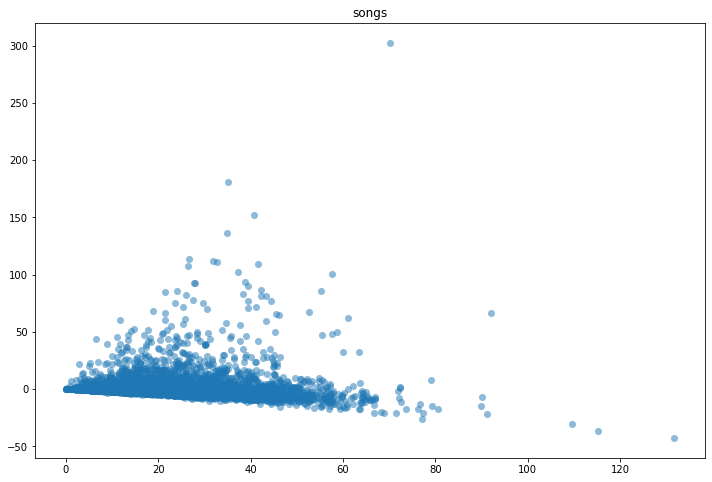

In [446]:
# vis
from   sklearn.decomposition import TruncatedSVD
import seaborn as sns
song_vis = TruncatedSVD(n_components=2).fit_transform(X)

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=song_vis[:, 0], 
    y=song_vis[:, 1],
    #hue=books_order['y'],
    #style=books_order['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('songs')
plt.show()

In [492]:
help = songs_trun[songs_trun['y_c']==max(song_vis[:,1])]
help.values

array([['Usher',
        'Oh my goshBaby let meI did it again, so I\'m gon\' let the beat rockOh myBaby, let me love you downThere\'s so many ways to love youBaby, I can break you downThere\'s so many ways to love youGot me like, "Oh my gosh", I\'m so in loveI found you finally, you make me want to sayOh oh oh-oh oh, oh oh oh-oh ohOh oh oh-oh oh, oh oh, oh my gosh(Oh oh oh-oh oh, oh oh oh-oh)You make me want to say(Oh oh oh-oh oh, oh oh oh-oh)Oh oh oh-oh oh, oh oh oh-ohI fell in love with shawty when I seen her on the dance floor(Oh oh oh-oh oh, oh oh oh-oh)She was dancing sexy, pop-pop-popping, dropping, dropping low(Oh oh oh-oh oh, oh oh oh-oh)Never ever has a lady hit me on the first sight(Oh oh oh-oh oh, oh oh oh-oh)This was something special, this was just like dynamite(Oh oh oh-oh oh, oh oh oh-oh)Honey got a booty like pow, pow, powHoney got some boobies like wow, oh wowGirl, you know I\'m loving your, loving your styleCheck, check, check, check, check, checking you out likeOhShe

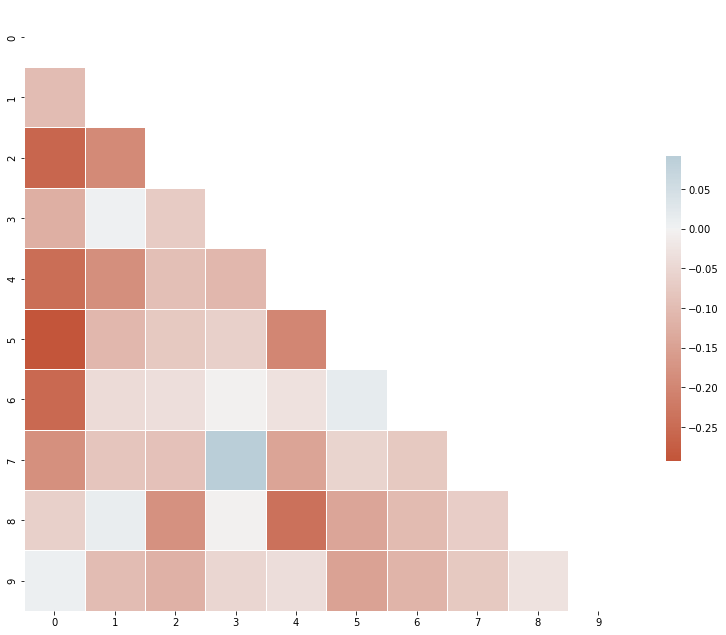

In [493]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from   sklearn.preprocessing import StandardScaler

#sns.set_context('talk')
corr = np.corrcoef(doc_topic_matrix.T)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask, 
    cmap=cmap, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)
plt.tight_layout()
plt.show()

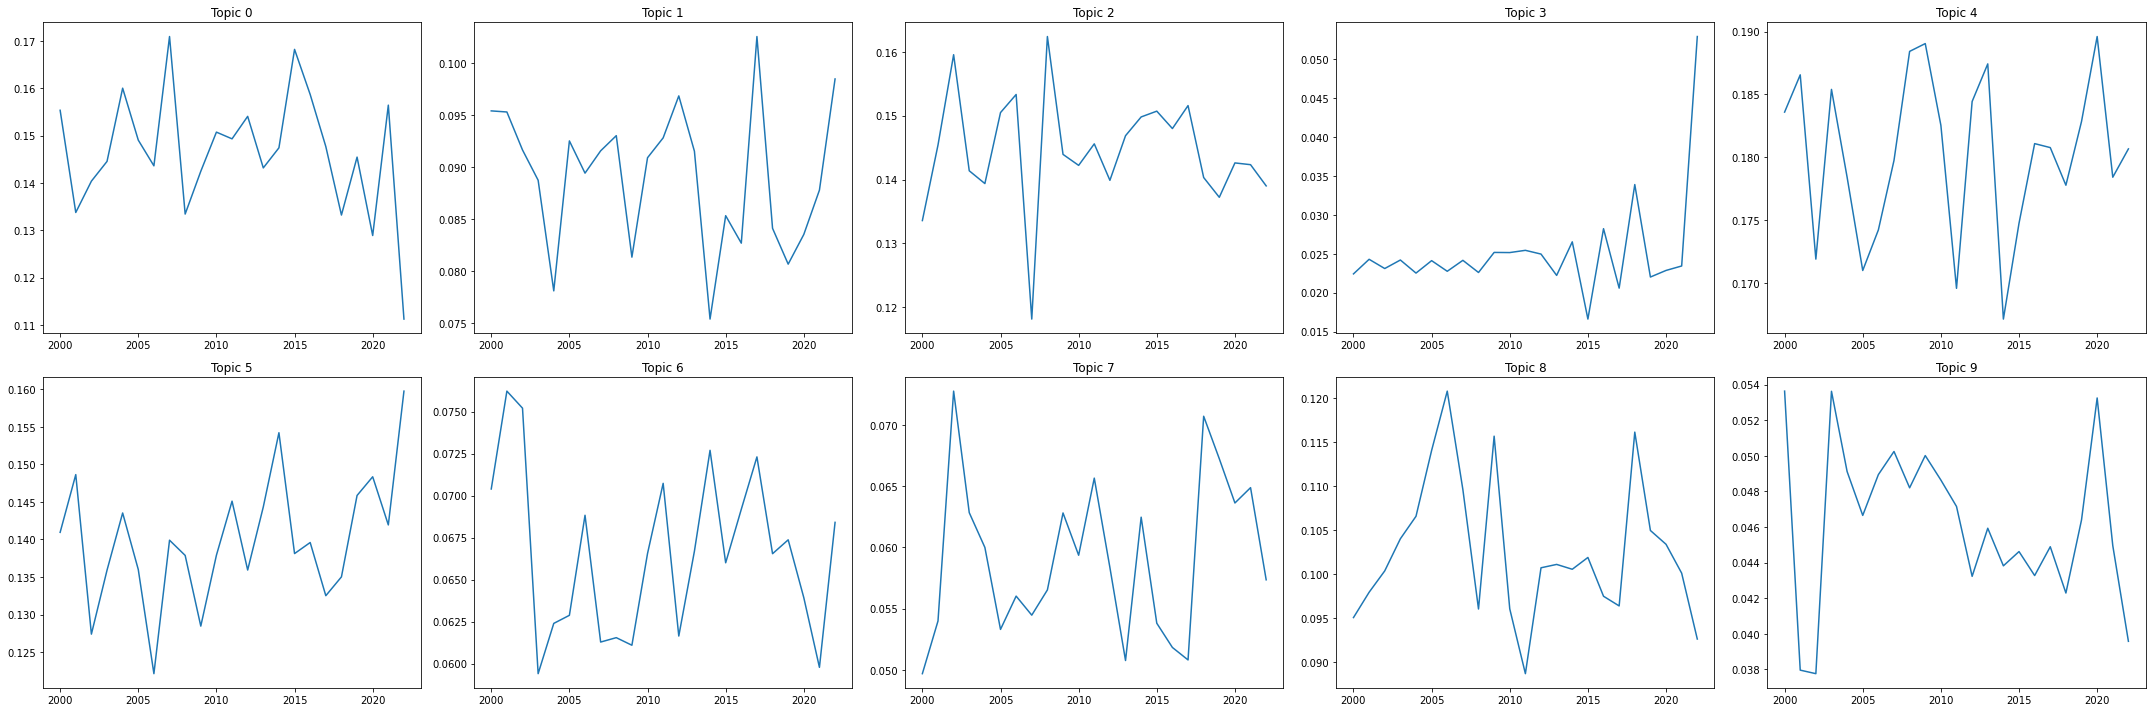

In [786]:
# code adapted from lecture 20-21 

# Time series
n_cols = 5
n_topics = doc_topic_matrix.shape[1]
n_rows = n_topics/n_cols
if n_rows%1!=0:
    n_rows += 1
n_rows = int(n_rows)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(30,10))
axs = axs.ravel()

valid_years = sorted(np.unique(songs_trun.year))


for topic in range(n_topics):
    topic_data = doc_topic_matrix[:,topic]
    topic_means = []
    for year in valid_years:
        mask = np.equal(years, year)
        topic_mean = np.mean(topic_data[mask.year.values])
        topic_means.append(topic_mean)
    axs[topic].plot(valid_years, topic_means)
    axs[topic].set_title(f'Topic {topic}')
plt.tight_layout()
plt.show()

Mean cross-validated R^2 (topics): -0.01


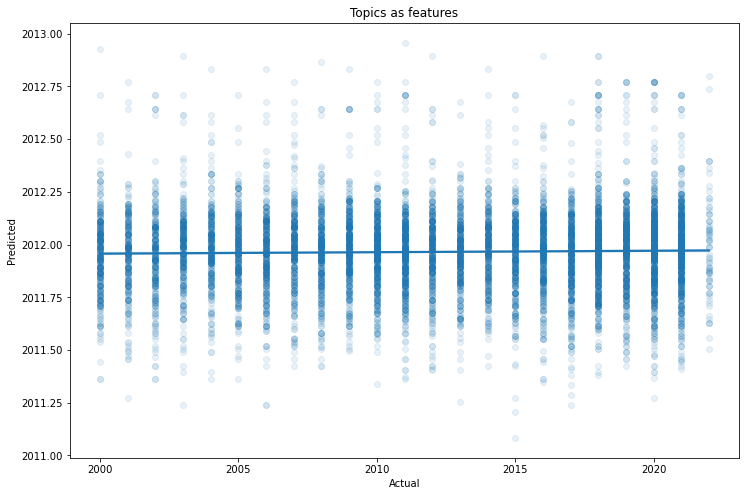

In [ ]:
from   sklearn.linear_model import LinearRegression
from   sklearn.model_selection import cross_val_score

# Fit and predict using topics
X_topics = StandardScaler().fit_transform(doc_topic_matrix)
predictor = LinearRegression().fit(X_topics, years)
y_pred = predictor.predict(X_topics)

# Score
print("Mean cross-validated R^2 (topics):", round(np.mean(cross_val_score(LinearRegression(), X_topics, years, scoring='r2', cv=10)),3))

# Plot
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x=years, y=y_pred, scatter_kws={'alpha':0.1})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Topics as features")
plt.show()

In [522]:
## new model bc last one so bad, need to lower perplexity

vectorizer = CountVectorizer( #token counts
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    #stop_words='english', 
    lowercase = True,
    min_df = 0.3, #chunk by song
    max_df = 0.5    
)

X = vectorizer.fit_transform(lyrics)
print("Feature matrix shape:", X.shape)
print("Total vectorized words in the corpus:", X.sum())
print("Average vectorized song length:", int(X.sum()/X.shape[0]), "tokens")

Feature matrix shape: (8468, 39)
Total vectorized words in the corpus: 409044
Average vectorized song length: 48 tokens


In [523]:
lda = LatentDirichletAllocation(
    n_components=5, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10, perplexity: 33.6679
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10, perplexity: 32.6148
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10, perplexity: 32.3183
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10, perplexity: 32.1709
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10, perplexity: 32.0652


LatentDirichletAllocation(evaluate_every=2, n_components=5, n_jobs=-1,
                          verbose=1)

In [524]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=20, hide_stops=False)

Topic  0: love they ain down let but now one say right from cause if take yeah at do make way see
Topic  1: oh yeah let baby go but now one cause make re love wanna come want right see do say time
Topic  2: she go was at see let ll but ain make back from they if time not now cause never do
Topic  3: ve never been baby back how time have come ll was now cause re see but at not love right
Topic  4: re do wanna want ll cause make if need not one baby let way take come say have see go



Mean cross-validated R^2 (topics): -0.01


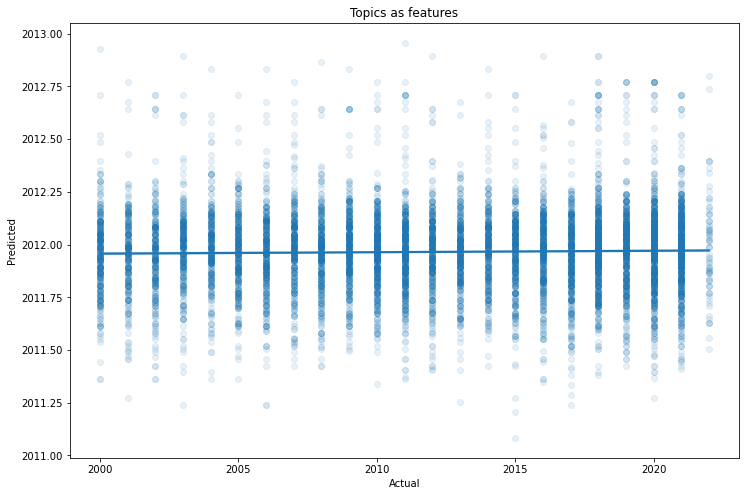

In [525]:
# Fit and predict using topics
X_topics = StandardScaler().fit_transform(doc_topic_matrix)
predictor = LinearRegression().fit(X_topics, years)
y_pred = predictor.predict(X_topics)

# Score
print("Mean cross-validated R^2 (topics):", round(np.mean(cross_val_score(LinearRegression(), X_topics, years, scoring='r2', cv=10)),3))

# Plot
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x=years, y=y_pred, scatter_kws={'alpha':0.1})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Topics as features")
plt.show()

In [529]:
# word embedding

In [530]:
def remove_noninformative_tokens(doc):
    '''
    Takes a spacy-processed document.
    Returns a list of spacy token objects without stopwords, punctuation, or embedding-less tokens.
    '''
    culled = [token for token in doc if not (token.is_stop or token.is_punct or token.is_space) and token.has_vector]
    return(culled)

def get_doc_embedding(text, nlp):
    '''
    Takes a document as a text string and a loaded spaCy nlp object.
    Returns a vector representation of the document.
    '''
    doc = nlp(text)
    culled = remove_noninformative_tokens(doc)
    embedding = np.mean([token.vector for token in culled], axis=0)
    if np.isnan(embedding).any():
        embedding = np.zeros([1,nlp.vocab.vectors_length])
        print(f"There was a problem with document {i}\nText: {text}\n")
    return(embedding)

In [533]:
%%time
# Vectorize embeddings
import spacy
import datetime
nlp = spacy.load("en_core_web_lg")

X_embed = np.zeros([len(songs_trun), nlp.vocab.vectors_length])
for i, text in enumerate(songs_trun.lyrics):
    if i%1000 == 0:
        print(f'{i:<5} documents processed @ {datetime.datetime.now()}')
    X_embed[i] = get_doc_embedding(text, nlp)
print(X_embed.shape)

0     documents processed @ 2022-05-18 19:15:20.831409
1000  documents processed @ 2022-05-18 19:16:39.415198
2000  documents processed @ 2022-05-18 19:17:58.641525
3000  documents processed @ 2022-05-18 19:19:13.863932
4000  documents processed @ 2022-05-18 19:20:27.343098
5000  documents processed @ 2022-05-18 19:21:40.870906
6000  documents processed @ 2022-05-18 19:22:58.566436
7000  documents processed @ 2022-05-18 19:24:28.220119
8000  documents processed @ 2022-05-18 19:25:56.422926
(8468, 300)
CPU times: user 11min 13s, sys: 3.59 s, total: 11min 17s
Wall time: 11min 18s


In [535]:
import pickle
with open('X_embed.pickle', 'wb') as f:
    pickle.dump(X_embed, f)

In [554]:
## what is our prediction task

# split up the gold labels by decade?

topic_data = doc_topic_matrix[:,1]
# matrix of each topic per document
#doc_topic_matrix.shape

(8468, 10)

In [ ]:
# make this into regression task now

In [753]:
# add decades column
songs['decade'] = (songs['year'].str[0:3].astype(int))*10

songs_trun['decade']=songs_trun['year'].astype(str)
songs_trun['decade'] = (songs_trun['decade'].str[0:3].astype(int))*10
songs_trun

,artist1,lyrics,g_url,year,decade
0,Santana,"Man, it's a hot oneLike seven inches from the ...",https://www.genius.com/Santana-Smooth-lyrics,2000.0,2000
1,Brian McKnight,It's undeniableThat we should be togetherIt's ...,https://www.genius.com/Brian-McKnight-Back-At-...,2000.0,2000
2,Jessica Simpson,"Ooh, ooh, mmmYou set my soul at easeChased dar...",https://www.genius.com/Jessica-Simpson-I-Wanna...,2000.0,2000
3,Whitney Houston,"Clap your hands, y'allIt's alright (Turn me up...",https://www.genius.com/Whitney-Houston-My-Love...,2000.0,2000
4,Savage Garden,"MmmOoh, ohMaybe it's intuitionBut some things ...",https://www.genius.com/Savage-Garden-I-Knew-I-...,2000.0,2000
...,...,...,...,...,...
8463,Juice WRLD,"She said it's not enoughOh-oh-oh, uhNow I've b...",https://www.genius.com/Juice-WRLD-Not-Enough-l...,2021.0,2020
8464,A Boogie Wit da Hoodie,Got it on Smash (OG Parker)Huh? She whisperin'...,https://www.genius.com/A-Boogie-Wit-da-Hoodie-...,2021.0,2020
8465,Juice WRLD,"Uh, yeahEcstasy-takin', rock star steezEcstasy...",https://www.genius.com/Juice-WRLD-From-My-Wind...,2021.0,2020
8466,Juice WRLD,"You know, I think more than meBecause he did a...",https://www.genius.com/Juice-WRLD-Relocate-lyrics,2021.0,2020


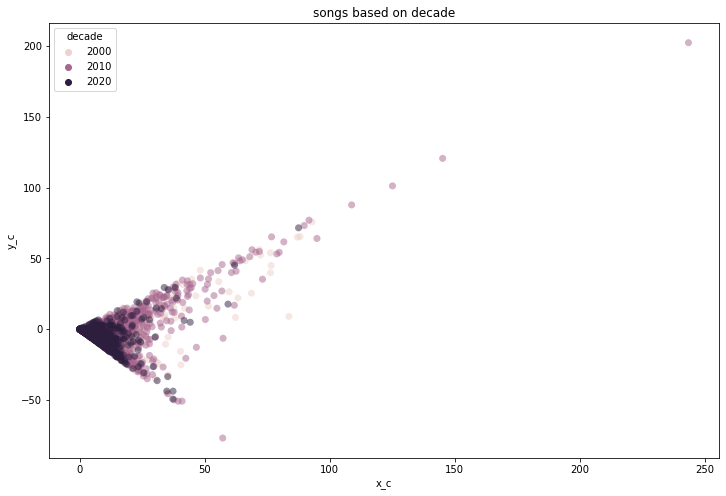

In [768]:
song_vis = TruncatedSVD(n_components=2).fit_transform(X)

songs_trun['x_c']=song_vis[:,0]
songs_trun['y_c']=song_vis[:,1]

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=songs_trun['x_c'], 
    y=songs_trun['y_c'],
    hue=songs_trun['decade'],
    #style=books_order['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('songs based on decade')
plt.show()

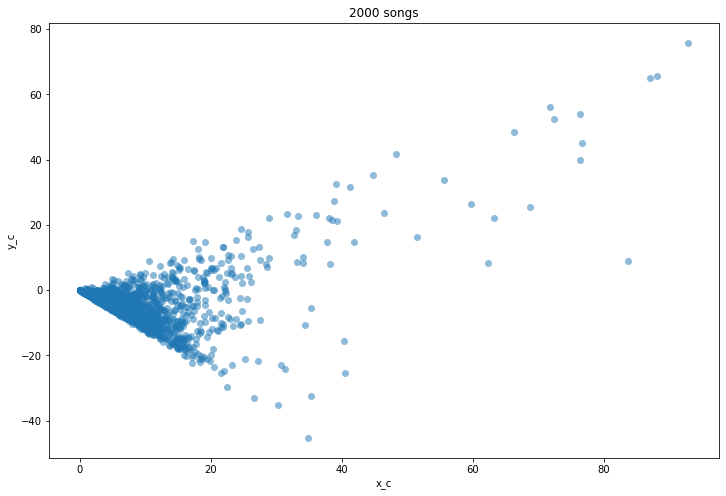

In [775]:
song_vis = TruncatedSVD(n_components=2).fit_transform(X)


songs_trun['x_c']=song_vis[:,0]
songs_trun['y_c']=song_vis[:,1]
songs2000 = songs_trun[songs_trun['decade'] == 2000]

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=songs2000['x_c'], 
    y=songs2000['y_c'],
    #hue=songs2000['year'],
    #style=books_order['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('2000 songs')
plt.show()

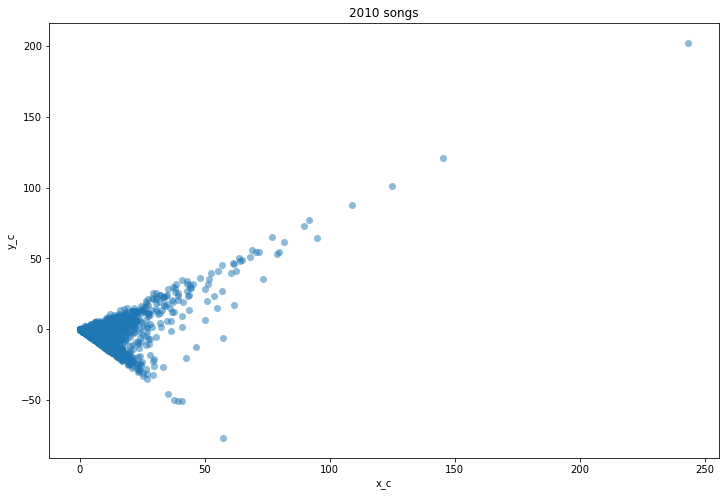

In [776]:
song_vis = TruncatedSVD(n_components=2).fit_transform(X)


songs_trun['x_c']=song_vis[:,0]
songs_trun['y_c']=song_vis[:,1]
songs2010 = songs_trun[songs_trun['decade'] == 2010]

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=songs2010['x_c'], 
    y=songs2010['y_c'],
    #hue=songs2010['decade'],
    #style=books_order['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('2010 songs')
plt.show()

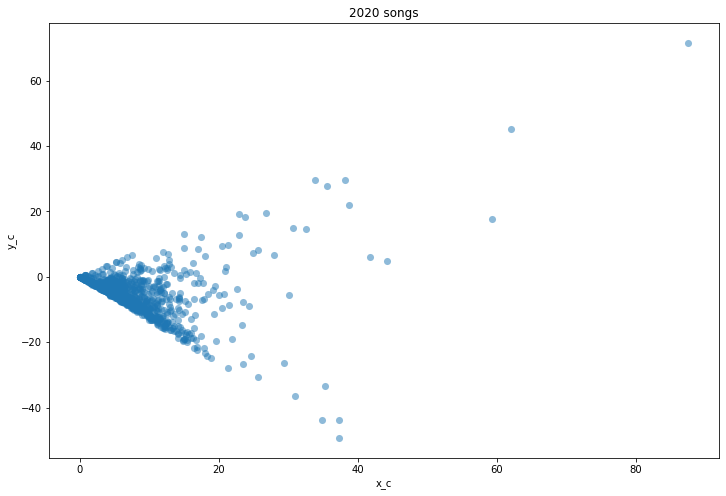

In [777]:
song_vis = TruncatedSVD(n_components=2).fit_transform(X)


songs_trun['x_c']=song_vis[:,0]
songs_trun['y_c']=song_vis[:,1]
songs2020 = songs_trun[songs_trun['decade'] == 2020]

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=songs2020['x_c'], 
    y=songs2020['y_c'],
    #hue=songs2020['decade'],
    #style=books_order['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('2020 songs')
plt.show()

In [770]:
#topic_means is the same length as the number of years
#gives mean for each year of each topic

In [720]:
# stat results for amount of mean topic per year based on doc term vector?

In [783]:
%%time
# Grid search: wide vs. deep, and compare solvers
from sklearn.model_selection import GridSearchCV

params = {
    'hidden_layer_sizes': [(300,), (100,), (10,), (2,), (100,10), (30,10), (10,2)],
    'solver':['adam', 'lbfgs'],
    'max_iter':[2000] # not part of the search, but set a classifier parameter
}
clf = GridSearchCV(vectorizer, params, n_jobs=-1)

# work with a subset of the data, to speed things up
#X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=2000)

# perform grid search
with warnings.catch_warnings() as w:
    warnings.simplefilter("ignore")
    clf.fit(X, songs_trun['decade']) # Note subset of the data!

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator CountVectorizer(max_df=0.5, min_df=0.3, strip_accents='unicode') does not.

In [ ]:
median1960 = songs1960[(songs1960['y_c'] > -.1)&(songs1960['y_c'] < .1)&(songs1960['x_c'] < 1)].sort_values(by='y_c')

print('Songs clustered at the origin: \n')
print(nn.g_url.values,'\n')
print('Lyrics to "Mint Julep" by Chet Atkins:')
print(nn[nn['g_url'] == 'https://www.genius.com/Chet-Atkins-One-Mint-Julep-lyrics'].lyrics.values)

print('\nLyrics to "The Batman Theme by The Marketts:')
print(nn[nn['g_url'] == 'https://www.genius.com/The-Marketts-Batman-Theme-lyrics'].lyrics.values)